In [1]:
%matplotlib inline

# Common imports



In [2]:
from Bio import SeqIO
from matplotlib import pyplot as plt
import numpy as np
import statsmodels.formula.api as smf
import pandas as pd

from scipy import stats
# # from scipy import spatial
# # import json

from collections import Counter


import datetime
year = datetime.date.today().year
month = datetime.date.today().month
import os
results_dir = '../Results/{}_{:02}'.format(year, month)
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

# Just some parameters to make prettier plots

In [3]:
import matplotlib
matplotlib.rcParams['xtick.labelsize'] = 10
matplotlib.rcParams['ytick.labelsize'] = 10
matplotlib.rcParams['axes.labelsize'] = 10
matplotlib.rcParams['axes.titlesize'] = 10

matplotlib.rcParams['axes.grid'] = True
matplotlib.rcParams['grid.color'] = '0.5'
matplotlib.rcParams['grid.linewidth'] = '0.5'

matplotlib.rcParams['axes.edgecolor'] = '0.25'
matplotlib.rcParams['xtick.color'] = '0'
matplotlib.rcParams['ytick.color'] = '0'

matplotlib.rcParams['xtick.major.width'] = 1
matplotlib.rcParams['ytick.major.width'] = 1
matplotlib.rcParams['ytick.major.size'] = 5
matplotlib.rcParams['xtick.major.size'] = 5
matplotlib.rcParams['axes.spines.right'] = True
matplotlib.rcParams['axes.spines.left'] = True
matplotlib.rcParams['axes.spines.top'] = True
matplotlib.rcParams['axes.spines.bottom'] = True

matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.sans-serif'] = 'Helvetica'
matplotlib.rcParams['font.weight']='normal'
matplotlib.rcParams['axes.axisbelow'] = True

# Some important parameters to toggle / note

In reading in the `.wig` files below, there is no offset and each read was assigned to the 3' most nucleotide in the read. With `mapping_offset` = 0, you're just reading in the `.wig` data in its raw form. I did this, and then adjusted the `mapping_offset` parameter so that the peak in the 5' meta-gene analysis lined up with the start codons (to get the peak to line up with the stop codon requires an offset of -9).

If we were trying to be *really* precise about mapping down to the single nucleotide/codon level, we might want to offset our reads differently depending on the different lengths of the read. By contrast, this current method offsets every read by a set amount regardless of the read length. In this current form of the analysis, however, we are not performing any codon-level analyses so +/- a single nucleotide or two won't make any substantial difference to overall translation efficiency averaged across a gene. **(Note: See the end of this notebook for an orthogonal way to visualize/test the validity of the offset using the secM stalling sequence)**

In [4]:
mapping_offset = -16
utr_length_to_include = 50

# Loading in / parsing the genome file

Note that this code (in its current form) is restricted to analyzing coding sequences (tagged CDS), and has several other filters that correspond to the same restrictions that I put on files that were used as input to other programs (Kallisto) such as not considering pseudogenes, etc.

Also note that the `full_sequence_dict` that I will use throughout includes flanking nucleotides up and downstream of the CDS according to the `utr_length_to_include` parameter defined above.

In [5]:
genome_file = '../Data/Genome_files/U00096.3.fasta'
genome_seq = list(SeqIO.parse(genome_file, 'fasta'))[0]
organism = 'Escherichia'

In [6]:
utr_sequence_dict = {}
full_sequence_dict = {}
strand_dict = {}
location_dict = {}
genbank_seq = list(SeqIO.parse('../Data/Genome_files/U00096.3.gb', 'genbank'))[0]
for feature in genbank_seq.features:
    if feature.type != 'CDS':
        continue
    elif 'pseudo' in feature.qualifiers:
        continue
    name = feature.qualifiers['locus_tag'][0] + '_' + feature.qualifiers['gene'][0]
    start = feature.location.start
    end = feature.location.end
    ###Sequence for positive strand genes
    if feature.strand == 1:
        seq = str(genbank_seq.seq[start-utr_length_to_include:end+utr_length_to_include])
    ###Sequence for negative strand genes needs to be reverse complemented
    elif feature.strand == -1:
        seq = str(genbank_seq.seq[start-utr_length_to_include:end+utr_length_to_include].reverse_complement())
    
    full_sequence_dict[name] = seq
    
    ###Separately just grab the 5'UTR as its own dictionary because it may be helpful
    utr_seq = seq[:utr_length_to_include]
    utr_sequence_dict[name] = utr_seq
    
    ###Store strand and locations
    strand_dict[name] = feature.strand
    location_dict[name] = (start, end)

print(len(utr_sequence_dict.keys()))
print(len(full_sequence_dict.keys()))
print(len(strand_dict.keys()))
print(len(location_dict.keys()))

4240
4240
4240
4240


**Just making sure I extracted everything okay above by counting start and stop codons**

In [7]:
starts = []
stops = []
for name,gene in list(full_sequence_dict.items())[:]:
    starts.append(gene[utr_length_to_include:utr_length_to_include+3])
    stops.append(gene[-3-utr_length_to_include:-utr_length_to_include])
print('####Start codons')
print(Counter(starts))
print('#####Stop codons')
print(Counter(stops))

####Start codons
Counter({'ATG': 3831, 'GTG': 327, 'TTG': 76, 'ATT': 4, 'CTG': 2})
#####Stop codons
Counter({'TAA': 2727, 'TGA': 1218, 'TAG': 294, 'ATG': 1})


# Reading in the .wig files

This analysis is predominantly going to be performed on the ribosome profiling data but the RNA-seq data presents a nice internal control for certain things.

These `.wig` files were constructed by using a custom python script to read through the `.sam` file of mapped reads and assign a count of 1 to the nucleotide located at the 3' end of the read (for positive strand mapped genes) or a count of 1 to the nucleotide located at the 5' end of the read (for negative strand mapped genes). A number of ways can be thought of to construct the `.wig` from `.sam` since some reads are multiply mapped. Current strategy is to only analyze so called "primary alignments" form HISAT2, but another strategy may be to divide/weight reads according to the number of "secondary alignments" at other locations in the genome. 

Also, note that my current strategy for offsetting below fails for reads that straddle the origin/terminus. I think it's like a read or two in each dataset but these aren't treated properly at the moment.

In [8]:
sample_files = [('WTrep1_ribo', '../Data/WIG_files/WTrep1.ribo_cigar_fulladjust_f.wig', '../Data/WIG_files/WTrep1.ribo_cigar_fulladjust_r.wig'),\
               ('WTrep2_ribo', '../Data/WIG_files/WTrep2.ribo_cigar_fulladjust_f.wig', '../Data/WIG_files/WTrep2.ribo_cigar_fulladjust_r.wig'),\
               ('RIBOTrep1_ribo', '../Data/WIG_files/RIBOTrep1.ribo_cigar_fulladjust_f.wig', '../Data/WIG_files/RIBOTrep1.ribo_cigar_fulladjust_r.wig'),\
               ('RIBOTrep2_ribo', '../Data/WIG_files/RIBOTrep2.ribo_cigar_fulladjust_f.wig', '../Data/WIG_files/RIBOTrep2.ribo_cigar_fulladjust_r.wig'),\
               ('WTrep1_rna', '../Data/WIG_files/WTrep1.rna_cigar_fulladjust_f.wig', '../Data/WIG_files/WTrep1.rna_cigar_fulladjust_r.wig'),\
               ('WTrep2_rna', '../Data/WIG_files/WTrep2.rna_cigar_fulladjust_f.wig', '../Data/WIG_files/WTrep2.rna_cigar_fulladjust_r.wig'),\
               ('RIBOTrep1_rna', '../Data/WIG_files/RIBOTrep1.rna_cigar_fulladjust_f.wig', '../Data/WIG_files/RIBOTrep1.rna_cigar_fulladjust_r.wig'),\
               ('RIBOTrep2_rna', '../Data/WIG_files/RIBOTrep2.rna_cigar_fulladjust_f.wig', '../Data/WIG_files/RIBOTrep2.rna_cigar_fulladjust_r.wig')]

sample_names = [i[0] for i in sample_files]

In [9]:
feature_dict_meta = {}
for sample_file in sample_files[:]:
    sample_name, fwd, rev = sample_file
    print('##### {}'.format(sample_name))
    feature_dict_meta[sample_name] = {}
    
    ################################
    ###Essentially get the fwd and rev genome coverage
    fwd_dicty = {}
    rev_dicty = {}
    with open(fwd) as infile:
        for line in enumerate(infile):
            if line[0] > 0:###Ignore the first line of the file
                split_line = line[1].split('\t')
                fwd_dicty[int(split_line[0])+mapping_offset] = float(split_line[1])#Note: mapping offset addition
    print('Done with fwd')
    with open(rev) as infile:
        for line in enumerate(infile):
            if line[0] > 0:###Ignore the first line of the file
                split_line = line[1].split('\t')
                rev_dicty[int(split_line[0])-mapping_offset] = float(split_line[1])#Note: mapping offset subtraction
    print('Done with rev')
    for gene_name in full_sequence_dict.keys():        
        ####Dealing with positive strand genes first
        if strand_dict[gene_name] == 1:
            ###Get all positions that I care about
            pos = (location_dict[gene_name][0]-utr_length_to_include, location_dict[gene_name][1]+utr_length_to_include)
            if pos[1] < pos[0]:
                print('found a bug')
                continue
            sequencing = []
            ###Append read values and if there are none, append zero
            for i in range(pos[0], pos[1]):
                try:
                    sequencing.append(fwd_dicty[i])
                except KeyError:
                    sequencing.append(0)
            feature_dict_meta[sample_name][gene_name] = sequencing
        ####And repeat for negative strand genes
        elif strand_dict[gene_name] == -1:
            pos = (location_dict[gene_name][0]-utr_length_to_include, location_dict[gene_name][1]+utr_length_to_include)
            if pos[1] < pos[0]:
                print('found a bug')
                continue
            sequencing = []
            for i in range(pos[0]+1, pos[1]+1):
                try:
                    sequencing.append(rev_dicty[i])
                except KeyError:
                    sequencing.append(0)
            feature_dict_meta[sample_name][gene_name] = sequencing[::-1]###Note the CRUCIAL reverse here

##### WTrep1_ribo
Done with fwd
Done with rev
##### WTrep2_ribo
Done with fwd
Done with rev
##### RIBOTrep1_ribo
Done with fwd
Done with rev
##### RIBOTrep2_ribo
Done with fwd
Done with rev
##### WTrep1_rna
Done with fwd
Done with rev
##### WTrep2_rna
Done with fwd
Done with rev
##### RIBOTrep1_rna
Done with fwd
Done with rev
##### RIBOTrep2_rna
Done with fwd
Done with rev


**Check total read numbers across all of these features (only considering the CDS)**

This number will be different from the actual reads mapped via HISAT2 since I'm only looking at reads mapped to the subset of CDS's that I'm considering here and the CDS itself. I believe that any normalization for read depth should be done based on this number rather than the total number of reads mapped. Also note that there will be a small amount of double counting in the case of overlapping genes but this should be relatively inconsequential

In [10]:
total_read_dict = {}
for i in sample_names:
    all_features = []
    for j in feature_dict_meta[i].values():
        all_features.extend(j[utr_length_to_include:-1*utr_length_to_include])
    print(i, np.sum(all_features))
    total_read_dict[i] = np.sum(all_features)

WTrep1_ribo 24352163.0
WTrep2_ribo 16772907.0
RIBOTrep1_ribo 13044283.0
RIBOTrep2_ribo 14807898.0
WTrep1_rna 4123236.0
WTrep2_rna 3904392.0
RIBOTrep1_rna 4237880.0
RIBOTrep2_rna 3057141.0


# Periodicity check
**Expecting ribosome profiling reads to be periodic and RNA-seq reads not to be**

####### WTrep1_ribo
####### WTrep2_ribo
####### RIBOTrep1_ribo
####### RIBOTrep2_ribo
####### WTrep1_rna
####### WTrep2_rna
####### RIBOTrep1_rna
####### RIBOTrep2_rna


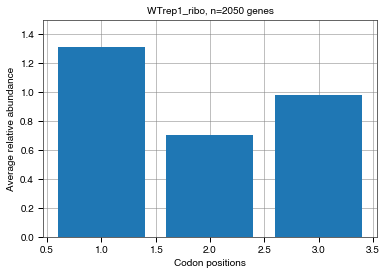

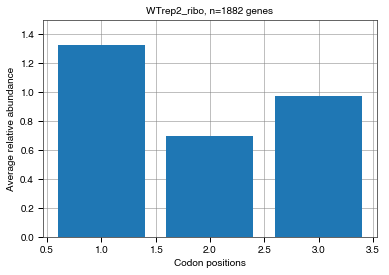

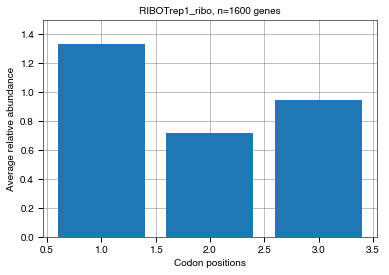

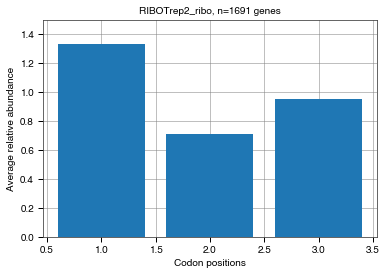

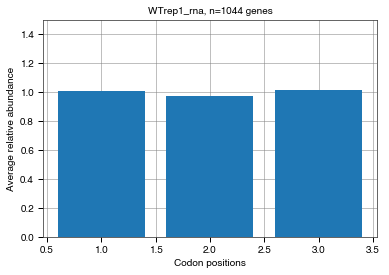

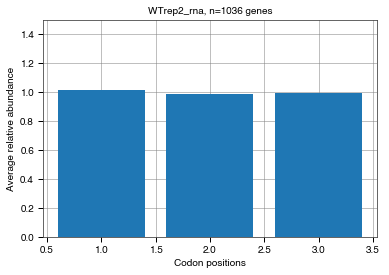

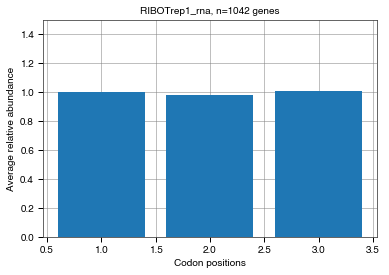

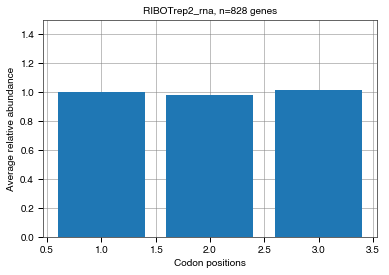

In [11]:
for sample in sample_names[:]:
    print('####### {}'.format(sample))
    valid_genes = 0
    first, second, third = [], [], []
    for name, reads in feature_dict_meta[sample].items():
        ###Extract just the CDS
        cds_reads = reads[utr_length_to_include:-1*utr_length_to_include]
        ###Actually, extract the center of the CDS to remove initiation/termination effects
        cds_reads = cds_reads[18:-18]
        meany = np.mean(cds_reads)
        
        ###Filter out low expression/coverage genes from this analysis
        if meany <= 0.5:
            continue
        if np.percentile(cds_reads, 80) <= 0:
            continue
            
        ###Normalize the reads for each gene
        cds_reads = np.array(cds_reads)/meany
        temp_first = cds_reads[0::3]
        temp_second = cds_reads[1::3]
        temp_third = cds_reads[2::3]
        first.extend(temp_first)
        second.extend(temp_second)
        third.extend(temp_third)
        valid_genes += 1

    fig, ax = plt.subplots()
    ax.bar([1, 2, 3], [np.mean(first), np.mean(second), np.mean(third)],\
               yerr=[np.std(first)/len(first), np.std(second)/len(second), np.std(third)/len(third)])
    ax.set_title('{}, n={} genes'.format(sample, valid_genes))
    ax.set_ylabel('Average relative abundance')
    ax.set_xlabel('Codon positions')
    ax.set_ylim(0, 1.5)
    plt.savefig('{}/{}_read_periodicity.pdf'.format(results_dir, sample), bbox_inches='tight')

# Get a list of genes that appear in all of the ribosome profiling datasets subject to some basic constraints

Constraints seem necessary but are entirely arbitrary here. I currently impose a length, coverage, and mean number of reads constraint

In [12]:
for i in sample_names:
    if i.find('_ribo') == -1:
        continue
    print('##################################')
    print(i, ' inititially has ', len(feature_dict_meta[i]), 'genes (sanity check)')
    to_delete = [] 
    for j in feature_dict_meta[i]:
        ####Length cutoff is to make sure each CDS is 100 nts long
        if len(feature_dict_meta[i][j]) < 100+(utr_length_to_include*2): 
            to_delete.append(j)
        ####Coverage cutoff is to make sure that at least 20% of the values in the CDS are non-zero
        elif np.percentile(feature_dict_meta[i][j][utr_length_to_include:-1*utr_length_to_include], 80) <= 0: ###Important parameter here, genes to discard based on coverage
            to_delete.append(j)
        ####Finally cut the lowest expression genes (mean less than 0.5)
        elif np.mean(feature_dict_meta[i][j][utr_length_to_include:-1*utr_length_to_include]) < 0.5:
            to_delete.append(j)
    for j in to_delete:
        del feature_dict_meta[i][j]
    print('now has', len(feature_dict_meta[i]), 'after coverage and length threshold')
    
genes_in_all_ribo = []
for gene in feature_dict_meta['WTrep1_ribo']:
    if gene not in feature_dict_meta['WTrep2_ribo']:
        continue
    if gene not in feature_dict_meta['RIBOTrep1_ribo']:
        continue
    if gene not in feature_dict_meta['RIBOTrep2_ribo']:
        continue
    genes_in_all_ribo.append(gene)

print('##################################')
print('##################################')
print('##################################')
print('There are', len(genes_in_all_ribo), 'genes that appear in all ribosome datasets')

##################################
WTrep1_ribo  inititially has  4240 genes (sanity check)
now has 2054 after coverage and length threshold
##################################
WTrep2_ribo  inititially has  4240 genes (sanity check)
now has 1891 after coverage and length threshold
##################################
RIBOTrep1_ribo  inititially has  4240 genes (sanity check)
now has 1648 after coverage and length threshold
##################################
RIBOTrep2_ribo  inititially has  4240 genes (sanity check)
now has 1726 after coverage and length threshold
##################################
##################################
##################################
There are 1597 genes that appear in all ribosome datasets


**Do the same for the RNA datasets (this will just be as a control)**

In [13]:
for i in sample_names:
    if i.find('_rna') == -1:
        continue
    print('##################################')
    print(i, ' inititially has ', len(feature_dict_meta[i]), 'genes (sanity check)')
    to_delete = [] 
    for j in feature_dict_meta[i]:
        ####Length cutoff is to make sure each CDS is 200 nts long
        if len(feature_dict_meta[i][j]) < 200: 
            to_delete.append(j)
        ####Coverage cutoff is to make sure that at least 20% of the values in the CDS are non-zero
        elif np.percentile(feature_dict_meta[i][j][utr_length_to_include:-1*utr_length_to_include], 80) <= 0: ###Important parameter here, genes to discard based on coverage
            to_delete.append(j)
        ####Finally cut the lowest expression genes (mean less than 0.5)
        elif np.mean(feature_dict_meta[i][j][utr_length_to_include:-1*utr_length_to_include]) < 0.5:
            to_delete.append(j)
    for j in to_delete:
        del feature_dict_meta[i][j]
    print('now has', len(feature_dict_meta[i]), 'after coverage and length threshold')
    
genes_in_all_rna = []
for gene in feature_dict_meta['WTrep1_rna']:
    if gene not in feature_dict_meta['WTrep2_rna']:
        continue
    if gene not in feature_dict_meta['RIBOTrep1_rna']:
        continue
    if gene not in feature_dict_meta['RIBOTrep2_rna']:
        continue
    genes_in_all_rna.append(gene)

print('##################################')
print('##################################')
print('##################################')
print('There are', len(genes_in_all_rna), 'genes that appear in all rna datasets')

##################################
WTrep1_rna  inititially has  4240 genes (sanity check)
now has 1026 after coverage and length threshold
##################################
WTrep2_rna  inititially has  4240 genes (sanity check)
now has 1012 after coverage and length threshold
##################################
RIBOTrep1_rna  inititially has  4240 genes (sanity check)
now has 1016 after coverage and length threshold
##################################
RIBOTrep2_rna  inititially has  4240 genes (sanity check)
now has 814 after coverage and length threshold
##################################
##################################
##################################
There are 777 genes that appear in all rna datasets


# Finally, subset out genes based on operon position to make the meta-analysis more clean 

This is pretty messy / slow. Ultimately perhaps not even important but a nice check to have nevertheless. I went back and verified from a few operons on EcoCyc that it outputs the correct results.

The basic premise here is to look at the 5' end of genes, perhaps we should ignore genes that are 2nd, 3rd, 4th, etc. in an operon since reads from the upstream gene will blur the signal that we care about. Likewise, looking at the 3' meta analysis we might want to ignore genes where there is another gene directly downstream of the stop codon which again will blur our signal.

In [14]:
genes_with_a_preceder = []
genes_with_a_follower = []
starts_positive_strand = []
starts_negative_strand = []
ends_positive_strand = []
ends_negative_strand = []
for gene in strand_dict.keys():
    if strand_dict[gene] == 1:
        starts_positive_strand.append(location_dict[gene][0])
        ends_positive_strand.append(location_dict[gene][1])
        assert starts_positive_strand[-1] < ends_positive_strand[-1]
    if strand_dict[gene] == -1:
        starts_negative_strand.append(location_dict[gene][1])
        ends_negative_strand.append(location_dict[gene][0])
        assert starts_negative_strand[-1] > ends_negative_strand[-1]

print('Compiled all starts/stops')
region_to_extend = 50
for i,j in enumerate(starts_positive_strand):
    starts_positive_strand[i] = list(range(j-region_to_extend,j+region_to_extend,1))
for i,j in enumerate(starts_negative_strand):
    starts_negative_strand[i] = list(range(j-region_to_extend,j+region_to_extend,1))
for i,j in enumerate(ends_positive_strand):
    ends_positive_strand[i] = list(range(j-region_to_extend,j+region_to_extend,1))
for i,j in enumerate(ends_negative_strand):
    ends_negative_strand[i] = list(range(j-region_to_extend,j+region_to_extend,1))
print('Extended all starts/stops by {}'.format(region_to_extend))

####Just put everyone together into a bigggg list/s
all_starts_positive = []
for i in starts_positive_strand:
    all_starts_positive.extend(i)
all_starts_negative = []
for i in starts_negative_strand:
    all_starts_negative.extend(i)
    
all_ends_positive = []
for i in ends_positive_strand:
    all_ends_positive.extend(i)
all_ends_negative = []
for i in ends_negative_strand:
    all_ends_negative.extend(i)
print('Finished concatenating the location of all starts/stops')
    
for gene in strand_dict.keys():
    if strand_dict[gene] == 1:
        start, end = location_dict[gene]
        if end in all_starts_positive:
            genes_with_a_follower.append(gene)
        if start in all_ends_positive:
            genes_with_a_preceder.append(gene)
    elif strand_dict[gene] == -1:
        end, start = location_dict[gene]
        if end in all_starts_negative:
            genes_with_a_follower.append(gene)
        if start in all_ends_negative:
            genes_with_a_preceder.append(gene)
        
print('Number of genes with a follower', len(genes_with_a_follower))
print('Number of genes with a preceder', len(genes_with_a_preceder))

Compiled all starts/stops
Extended all starts/stops by 50
Finished concatenating the location of all starts/stops
Number of genes with a follower 1527
Number of genes with a preceder 1524


In [15]:
print('Testing by strand')
print('Positive strand')
print(len([i for i in genes_with_a_follower if strand_dict[i] == 1]))
print(len([i for i in genes_with_a_preceder if strand_dict[i] == 1]))
print('Negative strand')
print(len([i for i in genes_with_a_follower if strand_dict[i] == -1]))
print(len([i for i in genes_with_a_preceder if strand_dict[i] == -1]))

Testing by strand
Positive strand
739
733
Negative strand
788
791


In [16]:
print(len(list(set(genes_with_a_follower + genes_with_a_preceder))))
print(len(list(genes_with_a_follower + genes_with_a_preceder)))

2316
3051


# 5' meta-analysis

A flag that I'll note here is `winsorize` which transforms the data slightly to mitigate the effect of outliers within each gene before subsequently taking column-averages across the genes for each position. It's not clear whether this is necessary (or helpful) but I found it to be a useful robustness check to ensure that the results are not dependent on findings from a few strongly outlying data points/peaks. Findings seem very robust regardless of the flag.

WTrep1_ribo
1080
WTrep2_ribo
1080
RIBOTrep1_ribo
1080
RIBOTrep2_ribo
1080


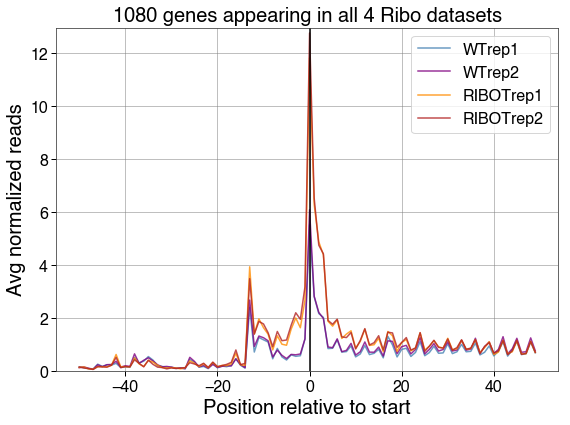

In [17]:
plotting_dict = {}
full_dict_temp = {}
winsorize = False
analysis_type = 'Ribo'
#####################################
#####################################
#####################################
if analysis_type == 'Ribo':
    samples_to_consider = sample_names[:4]
    genes_to_consider = genes_in_all_ribo
elif analysis_type == 'RNA':
    samples_to_consider = sample_names[4:]
    genes_to_consider = genes_in_all_rna
    
for sample in samples_to_consider:
    print(sample)
    temp_array = []
    for gene in genes_to_consider:
        if gene in genes_with_a_preceder:
            continue
#         if strand_dict[gene] == 1:
#             continue
        ###
        if winsorize:
            reads = stats.mstats.winsorize(np.array(feature_dict_meta[sample][gene]), axis=0, limits=0.05)
        else:
            reads = feature_dict_meta[sample][gene]
        ###
        meany = np.mean(reads[utr_length_to_include:-1*utr_length_to_include]) ###Calculate the mean based on the CDS only
        temp_array.append([i/meany for i in reads[:utr_length_to_include*2]])
    print(len(temp_array))
    y_vals = np.mean(np.array(temp_array), axis=0)
    plotting_dict[sample] = y_vals
    full_dict_temp[sample] = temp_array


x_vals = np.arange(-1*utr_length_to_include, utr_length_to_include, 1)
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(x_vals, plotting_dict[samples_to_consider[0]], c='steelblue', alpha=0.8, label='WTrep1')
ax.plot(x_vals, plotting_dict[samples_to_consider[1]], c='purple', alpha=0.8, label='WTrep2')
ax.plot(x_vals, plotting_dict[samples_to_consider[2]], c='darkorange', alpha=0.8, label='RIBOTrep1')
ax.plot(x_vals, plotting_dict[samples_to_consider[3]], c='firebrick', alpha=0.8, label='RIBOTrep2')
ax.legend(fontsize=16)
ax.set_title('{} genes appearing in all 4 {} datasets'.format(len(temp_array), analysis_type), fontsize=20)
ax.tick_params(labelsize=16)
ax.set_xlabel('Position relative to start', fontsize=20)
ax.set_ylabel('Avg normalized reads', fontsize=20)
maxy = max([max(plotting_dict[i]) for i in samples_to_consider]) 
ax.plot([0, 0], [0, maxy + 0.2], 'k-')
ax.set_ylim(0, maxy + 0.2)
plt.tight_layout()
if winsorize:
    plt.savefig('{}/5prime_{}_winsor.pdf'.format(results_dir, analysis_type), bbox_inches='tight')
else:
    plt.savefig('{}/5prime_{}_nowinsor.pdf'.format(results_dir, analysis_type), bbox_inches='tight')

In [ ]:
df = pd.DataFrame(index=x_vals)
for sample in samples_to_consider:
    df[sample] = plotting_dict[sample]

** Statistical significance. This is a very rough and preliminary way of calculating the significance at each point using a mixed linear model where each gene is a fixed effect. I think there are some issues with this, namely that the reads are not normally distributed and are more poisson/negative binomial/log-normal. So I take these p-values with a grain of salt but I'm unaware of a non-parametric mixed model implementation. And comparison with the RNA-seq reads shows a pretty stark difference **

In [ ]:
pval_listy = []
for position in range(100):
    print(position)
    df_stat = pd.DataFrame()
    for sample, temp_array in full_dict_temp.items():
        if 'WT' in sample:
            sample_name = 'WT'
        elif 'RIBOT' in sample:
            sample_name ='RIBOT'
        vals = np.array(temp_array).T[position]
        temp_df = pd.DataFrame()
        temp_df['value'] = vals
        temp_df['Condition'] = sample_name
        temp_df['gene_n'] = list(range(len(vals)))
        df_stat = pd.concat([df_stat, temp_df])
    md = smf.mixedlm('value~C(Condition)', df_stat, groups=df_stat['gene_n']).fit()
    pval_listy.append(md.pvalues[1])

In [ ]:
fig, ax = plt.subplots()
ax.semilogy(x_vals, pval_listy)
ax.axhline(0.01/100, c='r', linestyle='--')
ax.tick_params(labelsize=16)
ax.set_xlabel('Position relative to start', fontsize=20)
ax.set_ylabel('p-value from mixedlm', fontsize=20)
plt.tight_layout()
if winsorize:
    plt.savefig('{}/5prime_{}_pval_winsor.pdf'.format(results_dir, analysis_type), bbox_inches='tight')
else:
    plt.savefig('{}/5prime_{}_pval_nowinsor.pdf'.format(results_dir, analysis_type), bbox_inches='tight')

In [ ]:
df['mixedlm_pvalue'] = pval_listy

In [ ]:
if winsorize:
    df.to_csv('{}/5prime_{}_winsor.csv'.format(results_dir, analysis_type))
else:
    df.to_csv('{}/5prime_{}_nowinsor.csv'.format(results_dir, analysis_type))

# 3' Meta-analysis

Same as above repeated for the 3' end of genes

WTrep1_ribo
WTrep2_ribo
RIBOTrep1_ribo
RIBOTrep2_ribo


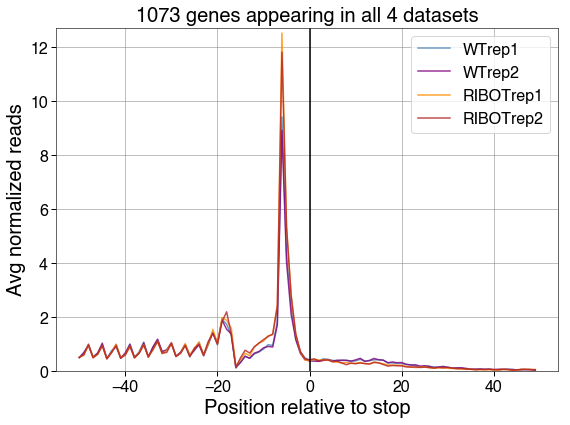

In [18]:
plotting_dict = {}
full_dict_temp = {}
winsorize = False

analysis_type = 'Ribo'
#####################################
#####################################
#####################################
if analysis_type == 'Ribo':
    samples_to_consider = sample_names[:4]
    genes_to_consider = genes_in_all_ribo
elif analysis_type == 'RNA':
    samples_to_consider = sample_names[4:]
    genes_to_consider = genes_in_all_rna
    
for sample in samples_to_consider:
    print(sample)
    temp_array = []
    for gene in genes_to_consider:
        if gene in genes_with_a_follower:
            continue
#         if strand_dict[gene] == 1:
#             continue
        if winsorize:
            reads = stats.mstats.winsorize(np.array(feature_dict_meta[sample][gene]), axis=0, limits=0.05)
        else:
            reads = feature_dict_meta[sample][gene]
        meany = np.mean(reads[utr_length_to_include:-1*utr_length_to_include]) ###Calculate the mean based on the CDS only
        temp_array.append([i/meany for i in reads[-1*utr_length_to_include*2:]])
    temp_array = stats.mstats.winsorize(np.array(temp_array), axis=0, limits=0.05)
    y_vals = np.mean(np.array(temp_array), axis=0)
    plotting_dict[sample] = y_vals
    full_dict_temp[sample] = temp_array

x_vals = np.arange(-1*utr_length_to_include, utr_length_to_include, 1)
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(x_vals, plotting_dict[samples_to_consider[0]], c='steelblue', alpha=0.8, label='WTrep1')
ax.plot(x_vals, plotting_dict[samples_to_consider[1]], c='purple', alpha=0.8, label='WTrep2')
ax.plot(x_vals, plotting_dict[samples_to_consider[2]], c='darkorange', alpha=0.8, label='RIBOTrep1')
ax.plot(x_vals, plotting_dict[samples_to_consider[3]], c='firebrick', alpha=0.8, label='RIBOTrep2')
ax.legend(fontsize=16)
ax.set_title('{} genes appearing in all 4 datasets'.format(len(temp_array)), fontsize=20)
ax.tick_params(labelsize=16)
ax.set_xlabel('Position relative to stop', fontsize=20)
ax.set_ylabel('Avg normalized reads', fontsize=20)
maxy = max([max(plotting_dict[i]) for i in samples_to_consider]) 
ax.plot([0, 0], [0, maxy + 0.2], 'k-')
ax.set_ylim(0, maxy + 0.2)
plt.tight_layout()
if winsorize:
    plt.savefig('{}/3prime_{}_winsor.pdf'.format(results_dir, analysis_type), bbox_inches='tight')
else:
    plt.savefig('{}/3prime_{}_nowinsor.pdf'.format(results_dir, analysis_type), bbox_inches='tight')

In [ ]:
df = pd.DataFrame(index=x_vals)
for sample in samples_to_consider:
    df[sample] = plotting_dict[sample]

** Stat sig **

In [ ]:
pval_listy = []
for position in range(100):
    print(position)
    df_stat = pd.DataFrame()
    for sample, temp_array in full_dict_temp.items():
        if 'WT' in sample:
            sample_name = 'WT'
        elif 'RIBOT' in sample:
            sample_name ='RIBOT'
        vals = np.array(temp_array).T[position]
        temp_df = pd.DataFrame()
        temp_df['value'] = vals
        temp_df['Condition'] = sample_name
        temp_df['gene_n'] = list(range(len(vals)))
        df_stat = pd.concat([df_stat, temp_df])
    md = smf.mixedlm('value~C(Condition)', df_stat, groups=df_stat['gene_n']).fit()
    pval_listy.append(md.pvalues[1])

In [ ]:
fig, ax = plt.subplots()
ax.semilogy(x_vals, pval_listy)
ax.axhline(0.01/100, c='r', linestyle='--')
ax.tick_params(labelsize=16)
ax.set_xlabel('Position relative to stop', fontsize=20)
ax.set_ylabel('p-value from mixedlm', fontsize=20)
plt.tight_layout()
if winsorize:
    plt.savefig('{}/3prime_{}_pval_winsor.pdf'.format(results_dir, analysis_type), bbox_inches='tight')
else:
    plt.savefig('{}/3prime_{}_pval_nowinsor.pdf'.format(results_dir, analysis_type), bbox_inches='tight')

In [ ]:
df['mixedlm_pvalue'] = pval_listy

In [ ]:
if winsorize:
    df.to_csv('{}/3prime_{}_winsor.csv'.format(results_dir, analysis_type))
else:
    df.to_csv('{}/3prime_{}_nowinsor.csv'.format(results_dir, analysis_type))

# Ensuring the proper offset

Additionally, the secM sequence has a known stalling sequence which should pause ribosomes with G165 located in the P-site and P166 in the A-site. A nice test of whether our P-site assignment via the meta-gene analysis is correct is to see whether we observe this peak for this single gene. We would of course expect to see it in the ribosome profiling reads and not the RNA-seq reads.

Nt position "495" that you see below just refers to 165\*3. Note that it is almost certainly better to assign reads to the **second** nucleotide of the codon so that slight deviations (+/- 1) still assign reads to the same P-site codon. However, this has the effect of making our peaks look shifted by 1 in nt space

In [19]:
for gene in feature_dict_meta['WTrep1_ribo']:
    if gene.find('secM') != -1:
        print(gene)

b0097_secM


(480, 510)

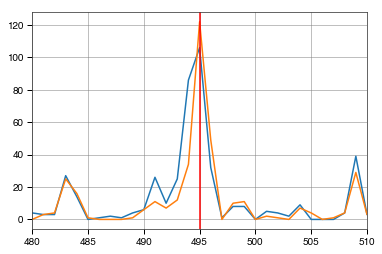

In [20]:
fig,ax = plt.subplots()
ax.plot(feature_dict_meta['WTrep1_ribo']['b0097_secM'][utr_length_to_include:-1*utr_length_to_include])
ax.plot(feature_dict_meta['WTrep2_ribo']['b0097_secM'][utr_length_to_include:-1*utr_length_to_include])
ax.axvline(495, c='r')
ax.set_xlim(480, 510)

(480, 510)

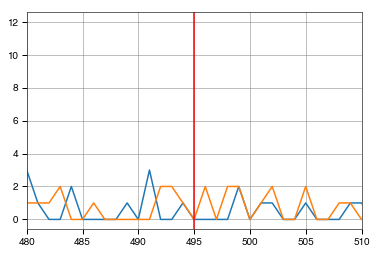

In [21]:
fig,ax = plt.subplots()
ax.plot(feature_dict_meta['WTrep1_rna']['b0097_secM'][utr_length_to_include:-1*utr_length_to_include])
ax.plot(feature_dict_meta['WTrep2_rna']['b0097_secM'][utr_length_to_include:-1*utr_length_to_include])
ax.axvline(495, c='r')
ax.set_xlim(480, 510)

# Re-writing .wig files to incorporate the offset

In [ ]:
sample_files = [('WTrep1_ribo', '../Data/WIG_files/WTrep1.ribo_cigar_fulladjust_f.wig', '../Data/WIG_files/WTrep1.ribo_cigar_fulladjust_r.wig'),\
               ('WTrep2_ribo', '../Data/WIG_files/WTrep2.ribo_cigar_fulladjust_f.wig', '../Data/WIG_files/WTrep2.ribo_cigar_fulladjust_r.wig'),\
               ('RIBOTrep1_ribo', '../Data/WIG_files/RIBOTrep1.ribo_cigar_fulladjust_f.wig', '../Data/WIG_files/RIBOTrep1.ribo_cigar_fulladjust_r.wig'),\
               ('RIBOTrep2_ribo', '../Data/WIG_files/RIBOTrep2.ribo_cigar_fulladjust_f.wig', '../Data/WIG_files/RIBOTrep2.ribo_cigar_fulladjust_r.wig'),\
               ('WTrep1_rna', '../Data/WIG_files/WTrep1.rna_cigar_fulladjust_f.wig', '../Data/WIG_files/WTrep1.rna_cigar_fulladjust_r.wig'),\
               ('WTrep2_rna', '../Data/WIG_files/WTrep2.rna_cigar_fulladjust_f.wig', '../Data/WIG_files/WTrep2.rna_cigar_fulladjust_r.wig'),\
               ('RIBOTrep1_rna', '../Data/WIG_files/RIBOTrep1.rna_cigar_fulladjust_f.wig', '../Data/WIG_files/RIBOTrep1.rna_cigar_fulladjust_r.wig'),\
               ('RIBOTrep2_rna', '../Data/WIG_files/RIBOTrep2.rna_cigar_fulladjust_f.wig', '../Data/WIG_files/RIBOTrep2.rna_cigar_fulladjust_r.wig')]

sample_names = [i[0] for i in sample_files]

**Mapping offset should be based on the above plots: meta-gene analyses and secM**

It's not entirely clear to me at the moment if these represent E, P, or A site mappings based on this and some other analyses not shown here. Start codons and secM would indicate that -16 is correct for this dataset but the stop codon peak is shifted pretty far in (more than 3 nts). Additionally I looked at correlations between different assignment offsets and tRNA adaptation index and it leads me to believe that we may be identifying the E-site rather than the P-site here.

I'll also note that I treat the "circular" nature of the genome kind of hackily and would need to think about this a bit more given the 0-based indexing nature of `Python`. I actually don't think any CDS's straddle the origin but if so they should be treated rather cautiously since there might be a +/- error for this infinitesmally tiny subset of reads that will be pushed over the replication origin/terminus based on the offset. 

Finally, all of my assumed offsets are negative so the code should only really apply to that since it was only tested on these. We map the 3' end, and then move the mappings upstream (in the 5' direction) accordingly. Downstream adjustments might require a few modifications to the below code

In [ ]:
#Mapping offset should be based on the above plots! Meta-gene analyses and secM
mapping_offset = -16

In [ ]:
genbank_seq = list(SeqIO.parse('../Data/Genome_files/U00096.3.gb', 'genbank'))[0]
total_genome_len = len(str(genbank_seq.seq))

for sample_file in sample_files[:]:
    sample_name, fwd, rev = sample_file
    print('##### {}'.format(sample_name))    
    ################################
    ###Get the adjusted fwd and rev genome coverage
    fwd_dicty = {}
    rev_dicty = {}
    top_line = ''
    with open(fwd) as infile:
        for line in enumerate(infile):
            if line[0] == 0:###Ignore the first line of the file
                top_line = line[1]
                continue
            split_line = line[1].split('\t')
            adjusted_position = int(split_line[0])+mapping_offset
            if adjusted_position >= 0:
                fwd_dicty[adjusted_position] = float(split_line[1])#Note: mapping offset addition
            else:
                fwd_dicty[total_genome_len-adjusted_position] = float(split_line[1])#Note: mapping offset addition    
    fwd_writing = sorted(fwd_dicty.items(), key=lambda x: x[0])
    with open(fwd.replace('_cigar_fulladjust_f.wig', '_putative_psite_f.wig'), 'w') as outfile:
        outfile.write(top_line)
        for i,j in fwd_writing:
            outfile.write('{}\t{}\n'.format(i,int(j)))
    print('Done with fwd')
    top_line = ''
    with open(rev) as infile:
        for line in enumerate(infile):
            if line[0] == 0:###Ignore the first line of the file
                top_line = line[1]
                continue
            split_line = line[1].split('\t')
            adjusted_position = int(split_line[0])-mapping_offset
            if adjusted_position <= total_genome_len:
                rev_dicty[adjusted_position] = float(split_line[1])#Note: mapping offset subtraction
            else:
                rev_dicty[adjusted_position-total_genome_len] = float(split_line[1])#Note: mapping offset subtraction
    rev_writing = sorted(rev_dicty.items(), key=lambda x: x[0])
    with open(rev.replace('_cigar_fulladjust_r.wig', '_putative_psite_r.wig'), 'w') as outfile:
        outfile.write(top_line)
        for i,j in rev_writing:
            outfile.write('{}\t{}\n'.format(i,int(j)))
    print('Done with rev')

# Scratch